In [209]:
from bokeh.charts   import Bar
from bokeh.plotting import figure
from bokeh.io       import output_notebook, show
from bokeh.layouts  import row
from bokeh.models   import ColumnDataSource
from bokeh.palettes import inferno

import pandas as pd
import numpy as np
from sklearn                 import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster         import KMeans
from sklearn.decomposition   import PCA

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0)

output_notebook()

Loading BokehJS ...

In [210]:
DF = pd.read_csv('nutrition_raw_anonymized_data.csv')
DF.head()

,ID,cancer,diabetes,heart_disease,belly,ever_smoked,currently_smoke,smoke_often,smoke_rarely,never_smoked,...,DT_FIBER_INSOL,DT_FIBER_SOL,DT_PROT_ANIMAL,DT_PROT_VEGETABLE,DT_NITROGEN,PHYTIC_ACID,OXALIC_ACID,COUMESTROL,BIOCHANIN_A,FORMONONETIN
0,1003,Yes,No,No,Innie,Yes,Yes,Yes,No,No,...,7.38,1.25,75.46,16.00,14.89,365.70,318.11,0.0117,0.0658,0.00324
1,1053,No,Yes,Yes,Outie,Yes,Yes,No,Yes,No,...,9.11,3.37,59.41,18.25,12.51,434.98,112.66,0.0107,0.1390,0.00743
2,1006,Yes,Yes,Yes,Innie,No,No,No,No,Yes,...,11.56,4.74,61.49,28.46,14.45,606.43,213.41,0.0965,0.0519,0.00946
3,1166,No,No,No,Innie,No,No,No,No,Yes,...,26.34,10.85,28.71,44.59,12.15,1570.07,334.08,0.2830,0.0890,0.01260
4,1134,Yes,No,No,Innie,No,No,No,No,Yes,...,16.48,4.80,32.41,28.23,9.80,616.99,422.55,0.1630,0.0994,0.02070


In [211]:
## Handle categorical data
DF.replace("Yes", 1, inplace=True)
DF.replace("No", 0, inplace=True)
DF.replace("Innie", 1, inplace=True)
DF.replace("Outie", 0, inplace=True)

## replace index with ID
DF.set_index(DF['ID'].values, inplace=True)
DF.drop("ID", axis=1, inplace=True)
DF.head()

,cancer,diabetes,heart_disease,belly,ever_smoked,currently_smoke,smoke_often,smoke_rarely,never_smoked,quit_smoking,...,DT_FIBER_INSOL,DT_FIBER_SOL,DT_PROT_ANIMAL,DT_PROT_VEGETABLE,DT_NITROGEN,PHYTIC_ACID,OXALIC_ACID,COUMESTROL,BIOCHANIN_A,FORMONONETIN
1003,1,0,0,1,1,1,1,0,0,0,...,7.38,1.25,75.46,16.00,14.89,365.70,318.11,0.0117,0.0658,0.00324
1053,0,1,1,0,1,1,0,1,0,0,...,9.11,3.37,59.41,18.25,12.51,434.98,112.66,0.0107,0.1390,0.00743
1006,1,1,1,1,0,0,0,0,1,0,...,11.56,4.74,61.49,28.46,14.45,606.43,213.41,0.0965,0.0519,0.00946
1166,0,0,0,1,0,0,0,0,1,0,...,26.34,10.85,28.71,44.59,12.15,1570.07,334.08,0.2830,0.0890,0.01260
1134,1,0,0,1,0,0,0,0,1,0,...,16.48,4.80,32.41,28.23,9.80,616.99,422.55,0.1630,0.0994,0.02070


In [212]:
## check if missing values
print("Missing values :", DF.isnull().values.any())

Missing values : False


The above function confirms that there are no missing values, so we can start exploring the data further.
<br><br><br>
The correlation matrix gives information about which dimenstions are strongly related to one another. It is a useful tool to analyse relations between dimensions.
<br>
In the correlation matrix below, the brighter a point, the more correlated its row and column i.e. if (x,y) is bright, then dimension 'x' and 'y' are correlated better. Obviuosly each dimension is perfectly correlated with itself, so the interesting points are the bright spots apart from the diagonal.

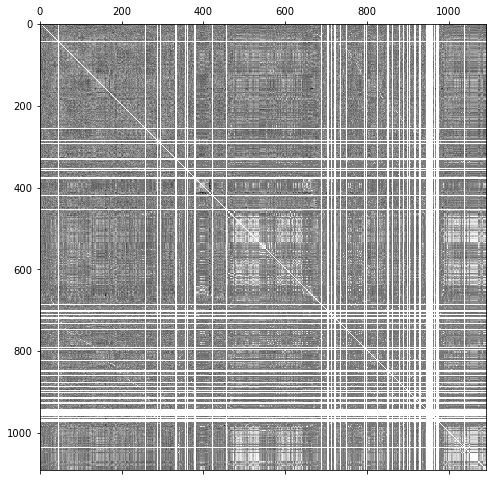

In [213]:
## matplotlib for correlation plot
plt.matshow(DF.corr())
plt.set_cmap('gray')
plt.show()

The matrix reveals that (approximately) the last 100 dimensions are correlated reasonably well among themselves. Also, dimension numbers around 500 are correlated well. So, lets see what they are, to get a better understanding of food trends that occur together. A brief look at this list gives a rough predictor regarding the impact of the said dimensions on the existence of disease.

In [214]:
list(DF.columns.values)[450:550]

['LATINO',
 'WHITE',
 'BLACK',
 'ASIAN',
 'NATIVEAMER',
 'HAWAIIAN',
 'NOTPROVIDED',
 'GROUP_SOLID_COUNT',
 'GROUP_SOLID_TOTAL_FREQUENCY',
 'GROUP_SOLID_TOTAL_GRAMS',
 'GROUP_ALCOHOLICBEVERAGES_TOTAL_KCAL',
 'GROUP_ALCOHOLICBEVERAGES_TOTAL_GRAMS',
 'GROUP_ALCOHOLICBEVERAGES_TOTAL_FREQUENCY',
 'GROUP_SUGARYBEVG_TOTAL_KCAL',
 'GROUP_SUGARYBEVG_TOTAL_GRAMS',
 'GROUP_SUGARYBEVG_TOTAL_FREQUENCY',
 'GROUP_A_SUGBEV_TOTAL_KCAL',
 'GROUP_A_SUGBEV_TOTAL_FREQUENCY',
 'GROUP_SWEETS_TOTAL_KCAL',
 'GROUP_SWEETS_TOTAL_GRAMS',
 'GROUP_SWEETS_TOTAL_FREQUENCY',
 'DT_KCAL',
 'DT_PROT',
 'DT_CARB',
 'DT_TFAT',
 'DT_ALCO',
 'DT_SUG_T',
 'DT_FIBE',
 'DT_MOIS',
 'DT_SFAT',
 'DT_MFAT',
 'DT_PFAT',
 'DT_CHOL',
 'DT_S040',
 'DT_S060',
 'DT_S080',
 'DT_S100',
 'DT_S120',
 'DT_S140',
 'DT_S160',
 'DT_S180',
 'DT_M161',
 'DT_M181',
 'DT_M201',
 'DT_M221',
 'DT_P182',
 'DT_P183',
 'DT_P184',
 'DT_P204',
 'DT_P205',
 'DT_P225',
 'DT_P226',
 'DT_VARAE',
 'DT_RET',
 'DT_ACARO',
 'DT_BCARO',
 'DT_CRYPT',
 'DT_LYCO',
 '

In [215]:
list(DF.columns.values)[-100:]

['GALS',
 'STARCH',
 'MN',
 'FLD',
 'NIACIN_EQUIV_NE',
 'PANTAC',
 'B_CAROTENE_EQUIV',
 'VITA_IU',
 'TOCPHB',
 'TOCPHG',
 'TOCPHD',
 'TOCTRA',
 'TOCTRB',
 'TOCTRG',
 'TOCTRD',
 'ERGCAL',
 'CHOCAL',
 'VITD_IU',
 'VITE_IU',
 'VITK1D',
 'MK4',
 'F13D0',
 'F15D0',
 'F17D0',
 'F20D0',
 'F22D0',
 'F24D0',
 'F14D1',
 'F15D1',
 'F16D1C',
 'F17D1',
 'F18D1C',
 'F22D1C',
 'F24D1C',
 'F18D2CN6',
 'F18D2CLA',
 'F18D2I',
 'F18D3CN3',
 'F18D3CN6',
 'F18D3I',
 'F20D2CN6',
 'F20D3',
 'F20D3N3',
 'F20D3N6',
 'F20D4N6',
 'F21D5',
 'F22D4',
 'F16D1T',
 'F18D1T',
 'F18D1TN7',
 'F22D1T',
 'F18D2TT',
 'F18D2T',
 'FATRNM',
 'FATRNP',
 'PHYSTR',
 'STID7',
 'CAMD5',
 'SITSTR',
 'TRP_G',
 'THR_G',
 'ILE_G',
 'LEU_G',
 'LYS_G',
 'MET_G',
 'CYS_G',
 'PHE_G',
 'TYR_G',
 'VAL_G',
 'ARG_G',
 'HISTN_G',
 'ALA_G',
 'ASP_G',
 'GLU_G',
 'GLY_G',
 'PRO_G',
 'SER_G',
 'HYP',
 'PAC_1',
 'PAC_2',
 'PAC_3',
 'PAC_4',
 'PAC_7',
 'PAC10',
 'BETN_C',
 'CHOLNFR',
 'CHOLNGPC',
 'CHOLNPC',
 'CHOLNPTC',
 'CHOLNSM',
 'DT_FIBER_INSOL

After a brief look at these columns, one can gather that they represent different vitamins and minerals(DT_VITD, DT_VITK) and other important intake data(DT_PROT_ANIMAL, GROUP_SWEETS_TOTAL_KCAL). So, from the correlation matrix itself, one prediction can be obatined as follows : important nutrients are generally well-correlated with one another. Also, these values are not well correlated with disease columns(which are the first few columns). So, the existence of disease might not be attributed to nutrient deficiency.

To further explore the data, clustering can be performed, to automatically identify natural clusters within the data. Since the original data is present in more than 1000 dimensions, Principal Component Analysis is applied to visualise the clustering results. Note that this is different from applying PCA and then clustering, since PCA can result in fome information loss.

In [216]:
# Obtain the 4 condition labels as separate Y vectors and drop corresponding columns from the DataFrame
Ycncr = list(DF["cancer"])
Ydbts = list(DF["diabetes"])
Yhrtd = list(DF["heart_disease"])
Yobst = list(DF["belly"])

DF.drop(["cancer", "diabetes", "heart_disease", "belly"],axis=1, inplace=True)

# Preprocess data by scaling to zero mean and unit variance
X = preprocessing.scale(DF)

In [236]:
## cancer classifier
X_train, X_test, y_train, y_test = train_test_split(X, Ycncr, test_size=0.25, random_state=0) # train on 3/4th
cluster = KMeans(n_clusters = 2).fit(X_train, y_train)
y_pred = cluster.predict(X_test)

# PCA on Xtest
reducer = PCA(n_components=2)
X_reduced = reducer.fit_transform(X_test)

# Plot predictions
CDSpred = ColumnDataSource(data={'x':X_reduced[:,0],
                                 'y':X_reduced[:,1],
                                 'legend':[inferno(2)[x] for x in y_pred]})
p1 = figure(title="Scatter plot with PCA, Predictions", width=400, height=400)
p1.scatter(x='x', y='y', source=CDSpred, fill_color='legend', size=7)

# Plot actual values
CDSactual = ColumnDataSource(data={'x':X_reduced[:,0],
                                   'y':X_reduced[:,1],
                                   'legend':[inferno(2)[x] for x in y_test]})
p2 = figure(title="Scatter plot with PCA, Ground Truth", width=400, height=400)
p2.scatter(x='x', y='y', source=CDSactual, fill_color='legend', size=7)

layout = row(p1, p2)
show(layout)

From the above, we gather that k-means clustering fails to capture the relation of nutritional factors with respect to cancer detection. K-means discovers blobs, which do not in fact correspong to the real data.

In [235]:
## diabetes clustering
X_train, X_test, y_train, y_test = train_test_split(X, Ydbts, test_size=0.25, random_state=0) # train on 3/4th
cluster = KMeans(n_clusters = 2).fit(X_train, y_train)
y_pred = cluster.predict(X_test)

# PCA on Xtest
reducer = PCA(n_components=2)
X_reduced = reducer.fit_transform(X_test)

# Plot predictions
CDSpred = ColumnDataSource(data={'x':X_reduced[:,0],
                                 'y':X_reduced[:,1],
                                 'legend':[inferno(2)[x] for x in y_pred]})
p1 = figure(title="Scatter plot with PCA, Predictions", width=400, height=400)
p1.scatter(x='x', y='y', source=CDSpred, fill_color='legend', size=7)

# Plot actual values
CDSactual = ColumnDataSource(data={'x':X_reduced[:,0],
                                   'y':X_reduced[:,1],
                                   'legend':[inferno(2)[x] for x in y_test]})
p2 = figure(title="Scatter plot with PCA, Ground Truth", width=400, height=400)
p2.scatter(x='x', y='y', source=CDSactual, fill_color='legend', size=7)

layout = row(p1, p2)
show(layout)

From the above, we can conclude that the data is somwehat useful for predicting clusters of diabetic persons. The points that are noticeably close by, are assigned mostly to the same cluster.
<br><br><br>

In [234]:
## heart disease clustering
X_train, X_test, y_train, y_test = train_test_split(X, Yhrtd, test_size=0.25, random_state=0) # train on 3/4th
cluster = KMeans(n_clusters = 2).fit(X_train, y_train)
y_pred = cluster.predict(X_test)

# PCA on Xtest
reducer = PCA(n_components=2)
X_reduced = reducer.fit_transform(X_test)

# Plot predictions
CDSpred = ColumnDataSource(data={'x':X_reduced[:,0],
                                 'y':X_reduced[:,1],
                                 'legend':[inferno(2)[x] for x in y_pred]})
p1 = figure(title="Scatter plot with PCA, Predictions", width=400, height=400)
p1.scatter(x='x', y='y', source=CDSpred, fill_color='legend', size=7)

# Plot actual values
CDSactual = ColumnDataSource(data={'x':X_reduced[:,0],
                                   'y':X_reduced[:,1],
                                   'legend':[inferno(2)[x] for x in y_test]})
p2 = figure(title="Scatter plot with PCA, Ground Truth", width=400, height=400)
p2.scatter(x='x', y='y', source=CDSactual, fill_color='legend', size=7)

layout = row(p1, p2)
show(layout)

In [233]:
## obesity clustering
X_train, X_test, y_train, y_test = train_test_split(X, Yobst, test_size=0.25, random_state=0) # train on 3/4th
cluster = KMeans(n_clusters = 2).fit(X_train, y_train)
y_pred = cluster.predict(X_test)

# PCA on Xtest
reducer = PCA(n_components=2)
X_reduced = reducer.fit_transform(X_test)

# Plot predictions
CDSpred = ColumnDataSource(data={'x':X_reduced[:,0],
                                 'y':X_reduced[:,1],
                                 'legend':[inferno(2)[x] for x in y_pred]})
p1 = figure(title="Scatter plot with PCA, Predictions", width=400, height=400)
p1.scatter(x='x', y='y', source=CDSpred, fill_color='legend', size=7)

# Plot actual values
CDSactual = ColumnDataSource(data={'x':X_reduced[:,0],
                                   'y':X_reduced[:,1],
                                   'legend':[inferno(2)[x] for x in y_test]})
p2 = figure(title="Scatter plot with PCA, Ground Truth", width=400, height=400)
p2.scatter(x='x', y='y', source=CDSactual, fill_color='legend', size=7)

layout = row(p1, p2)
show(layout)